In [2]:
#3 sections as per tutorial
#1 - Table detection using openCV
#2 - Thorough allocation of the cells to the proper row and column
#3 - Extraction of each allocated cell through OCR using pyTesseract

In [3]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import os

In [4]:
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

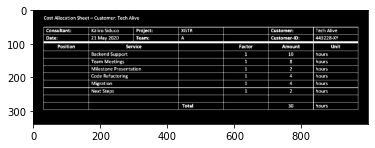

In [7]:
#Step 1 - REading the image and detecting the table using openCv
#The first step is to read in your file from the proper path, 
#using thresholding to convert the input image to a binary image and 
#inverting it to get a black background and white lines and fonts.

#reading the image
file = r'C:\Users\Alpesh\OneDrive\Desktop\table.png'
img = cv2.imread(file,0)
img.shape

#thresholding the image to a binary image
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)

#inverting the image 
img_bin = 255-img_bin
cv2.imwrite('/Users/YOURPATH/cv_inverted.png',img_bin)

#Plotting the image to see the output
plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

In [8]:
os.getcwd()

'C:\\Users\\Alpesh\\Downloads'

In [9]:
#Step 2 - Defining a kernel to detect the rectangular boxes and thus the tabular structure
#Firstly, define the length of the kernel and then the vertical and horizontal kernels
#this helps in detecting all the vertical and horizontal lines

# Length(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100

# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))

# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

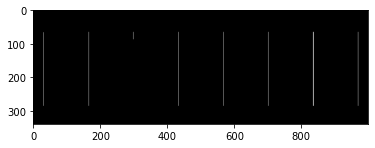

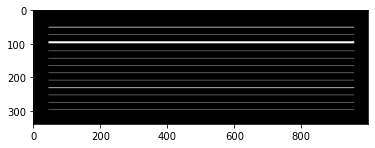

In [16]:
#step 3 - Detection of vertical and horizontal lines

#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
cv2.imwrite("/Users/YOURPATH/vertical.jpg",vertical_lines)

#Plot the generated image
plotting = plt.imshow(image_1,cmap='gray')
plt.show()

#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
cv2.imwrite("/Users/YOURPATH/horizontal.jpg",horizontal_lines)

#Plot the generated image
plotting = plt.imshow(image_2,cmap='gray')
plt.show()

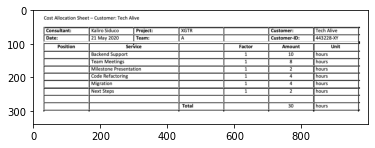

In [17]:
# Combining the two images above
#Eroding and thresholding the image

# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite('table.png', img_vh)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

#Plotting the generated image
plotting = plt.imshow(bitnot,cmap='gray')
plt.show()

In [18]:
#Detecting contours

# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return cnts, boundingBoxes

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours,method= "top-to-bottom")

In [19]:
#Retrieving the cells position

#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

#Get mean of heights
mean = np.mean(heights)

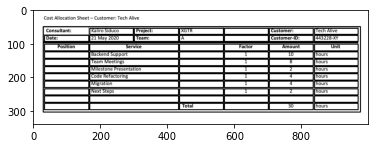

In [20]:
#Create a list and add dimensions of rectangles
#Width and height limits are adjustable since the image sizes vary
#1000 for w and 500 for h are not fixed values

#Create list box to store all boxes in  
box = []

# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if w < 1000 and h < 500:
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
plotting = plt.imshow(image,cmap='gray')
plt.show()

In [21]:
#Now as we have every cell, its location, height and width we need to get the right 
#location within the table. Therefore, we need to know in which row and which column it is located. 
#As long as a box does not differ more than its own (height + mean/2) the box is in the same row. 
#As soon as the height difference is higher than the current (height + mean/2) , 
#we know that a new row starts. Columns are logically arranged from left to right.

#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0

#Sorting the boxes to their respective row and column
for i in range(len(box)):
    if i==0:
        column.append(box[i])
        previous=box[i]
    else:
        if box[i][1]<=previous[1]+mean/2:
            column.append(box[i])
            previous=box[i]
            if i==len(box)-1:
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
print(column)
print(row)

#Max number of columns in final dataframe
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

[[840, 277, 130, 19], [705, 277, 131, 19], [571, 277, 131, 19], [437, 277, 131, 19], [169, 277, 265, 19], [34, 277, 132, 19]]
[[[30, 49, 947, 254], [840, 54, 130, 18], [705, 54, 131, 18], [571, 54, 131, 18], [437, 54, 131, 18], [302, 54, 132, 18], [169, 54, 130, 18]], [[840, 75, 130, 18], [705, 75, 131, 18], [571, 75, 131, 18], [437, 75, 131, 18], [302, 75, 132, 18], [169, 75, 130, 18], [34, 75, 132, 18]], [[840, 101, 130, 20], [705, 101, 131, 20], [571, 101, 131, 20], [437, 101, 131, 20], [169, 101, 265, 20], [34, 101, 132, 20]], [[840, 124, 130, 19], [705, 124, 131, 19], [571, 124, 131, 19], [437, 124, 131, 19], [169, 124, 265, 19], [34, 124, 132, 19]], [[840, 146, 130, 19], [705, 146, 131, 19], [571, 146, 131, 19], [437, 146, 131, 19], [169, 146, 265, 19], [34, 146, 132, 19]], [[840, 168, 130, 18], [705, 168, 131, 18], [571, 168, 131, 18], [437, 168, 131, 18], [169, 168, 265, 18], [34, 168, 132, 18]], [[840, 189, 130, 19], [705, 189, 131, 19], [571, 189, 131, 19], [437, 189, 131, 19

In [22]:
#Storing midpoint of each column in a list
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

In [23]:
print(row)
print(center)
print(countcol)

[[[30, 49, 947, 254], [840, 54, 130, 18], [705, 54, 131, 18], [571, 54, 131, 18], [437, 54, 131, 18], [302, 54, 132, 18], [169, 54, 130, 18]], [[840, 75, 130, 18], [705, 75, 131, 18], [571, 75, 131, 18], [437, 75, 131, 18], [302, 75, 132, 18], [169, 75, 130, 18], [34, 75, 132, 18]], [[840, 101, 130, 20], [705, 101, 131, 20], [571, 101, 131, 20], [437, 101, 131, 20], [169, 101, 265, 20], [34, 101, 132, 20]], [[840, 124, 130, 19], [705, 124, 131, 19], [571, 124, 131, 19], [437, 124, 131, 19], [169, 124, 265, 19], [34, 124, 132, 19]], [[840, 146, 130, 19], [705, 146, 131, 19], [571, 146, 131, 19], [437, 146, 131, 19], [169, 146, 265, 19], [34, 146, 132, 19]], [[840, 168, 130, 18], [705, 168, 131, 18], [571, 168, 131, 18], [437, 168, 131, 18], [169, 168, 265, 18], [34, 168, 132, 18]], [[840, 189, 130, 19], [705, 189, 131, 19], [571, 189, 131, 19], [437, 189, 131, 19], [169, 189, 265, 19], [34, 189, 132, 19]], [[840, 211, 130, 19], [705, 211, 131, 19], [571, 211, 131, 19], [437, 211, 131, 1

In [25]:
#Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []

for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

In [40]:
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

In [41]:
#Section 3 - Extraction of values

#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if len(finalboxes[i][j])==0:
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if len(out)==0:
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)

In [42]:
#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
print(dataframe)
data = dataframe.style.set_properties(align="left")

#Converting it in a excel-file
data.to_excel("output.xlsx")

               0                                                  1  \
0                      \n  \n\n{ Consultant:\nDate:\n\n  \n  \n\...   
1       Date:\n                            Team:\n 21 May 2020\n   
2    Position\n                                         Service\n   
3                                               Backend Support\n   
4                                                 Team Meetings\n   
5                                        Milestone Presentation\n   
6                                              Code Refactoring\n   
7                                                     Migration\n   
8                                                    Next Steps\n   
9                                                                   
10                                                                  

            2           3                 4               5  
0     XGTR\n                 Customer:\n   Tech Alive\n  
1                     

In [44]:
import os
os.getcwd()


'C:\\Users\\Alpesh\\Downloads'